# Conformalized quantile regression: A synthetic example (1)

This notebook replicates the first synthetic example, provided in [1].

In this tutorial we will create synthetic 1-dimensional heteroscedastic data, and compare the usual split conformal prediction [2], its locally weighted variant [3], and the proposed conformalized quantile regression (CQR) [1] alternative. The regression function used in this experiment is random forests.


[1] Yaniv Romano, Evan Patterson, and Emmanuel J. Candes, “Conformalized quantile regression.” 2019.

[2] Papadopoulos Harris, Kostas Proedrou, Volodya Vovk, and Alex Gammerman. “Inductive confidence machines for regression.” In European Conference on Machine Learning, pp. 345-356. Springer, Berlin, Heidelberg, 2002.

[3] Papadopoulos Harris, Alex Gammerman, and Volodya Vovk. “Normalized nonconformity measures for regression conformal prediction.” In Proceedings of the IASTED International Conference on Artificial Intelligence and Applications, pp. 64-69. 2008.



## Prediction intervals

Suppose we are given $ n $ training samples $ \{(X_i, Y_i)\}_{i=1}^n$ and we must now predict the unknown value of $Y_{n+1}$ at a test point $X_{n+1}$. We assume that all the samples $ \{(X_i,Y_i)\}_{i=1}^{n+1} $ are drawn exchangeably$-$for instance, they may be drawn i.i.d.$-$from an arbitrary joint distribution $P_{XY}$ over the feature vectors $ X\in \mathbb{R}^p $ and response variables $ Y\in \mathbb{R} $. We aim to construct a marginal distribution-free prediction interval $C(X_{n+1}) \subseteq \mathbb{R}$ that is likely to contain the unknown response $Y_{n+1} $. That is, given a desired miscoverage rate $ \alpha $, we ask that
$$ \mathbb{P}\{Y_{n+1} \in C(X_{n+1})\} \geq 1-\alpha $$
for any joint distribution $ P_{XY} $ and any sample size $n$. The probability in this statement is marginal, being taken over all the samples $ \{(X_i, Y_i)\}_{i=1}^{n+1} $.


In [ ]:
!pip install scikit-garden

     |████████████████████████████████| 317kB 5.5MB/s 
  Created wheel for scikit-garden: filename=scikit_garden-0.1.3-cp36-cp36m-linux_x86_64.whl size=665189 sha256=4d6adb5963b8e4f9454da97b98f476d49beae3157839bbbf60b4cc1f1aed27a9
  Stored in directory: /root/.cache/pip/wheels/d0/ef/71/3a032ba9a2b70690c9f9ec2e383afee6610f509af312ff2cf3
Successfully built scikit-garden


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
dataset_path = "/content/drive/My Drive/cqr/data.csv"
df = pd.read_csv(dataset_path)
df.head()

del df['first_fatalities']
del df['first_confirmed_case']
del df['Date']

df=df.fillna(0)
df=df.fillna(0)

data = df.values

ix = [ i for i in range ( data.shape[1]) if i != 2]
X, y = data [:,ix],data[:,3]

In [ ]:
import sys
sys.path.insert(1,"/content/drive/My Drive/cqr")
from cqr import helper

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklear

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np
np.warnings.filterwarnings('ignore')

%matplotlib inline
np.random.seed(1)

# desired miscoverage error
alpha = 0.1
# low and high target quantiles
quantiles = [5, 95]



# parameters of random forests
n_estimators = 50
min_samples_leaf = 1
max_features = x_train.shape[1] # 1D signal
random_state = 1

In [ ]:
# number of training examples
n_train = x_train.shape[0]
# number of test examples (to evaluate average coverage and length)
n_test = x_test.shape[0]



## CQR: Conformalized quantile regression

We begin by splitting the data into a proper training set, indexed by $I_1$, and a calibration set, indexed by $I_2$. 

In [ ]:
# divide the data into proper training set and calibration set
idx = np.random.permutation(n_train)
n_half = int(np.floor(n_train/2))
idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

Given any quantile regression algorithm $\mathcal{A}$ (the function `QuantileForestRegressorAdapter` in the code below), we then fit two conditional quantile functions $\hat{q}_{\alpha_{lo}}$ and $\hat{q}_{\alpha_{hi}}$ on the proper training set: $$ \{ \hat{q}_{\alpha_{lo}}, \hat{q}_{\alpha_{hi}} \} \leftarrow \mathcal{A}(\left\lbrace (X_i, Y_i): i \in I_1 \right\rbrace). $$
This is done by calling the function `icp.fit`.

In the essential next step, the function `icp.calibrate` computes conformity scores (using `QuantileRegErrFunc`) that quantify the error made by the plug-in prediction interval $ \hat{C}(x) = [\hat{q}_{\alpha_{lo}}(x), \ \hat{q}_{\alpha_{hi}}(x)]  $. The scores are evaluated on the calibration set as
$$
	E_i := \max\{\hat{q}_{\alpha_{lo}}(X_i) - Y_i, Y_i - \hat{q}_{\alpha_{hi}}(X_i)\},
$$
for each $i \in I_2$. The conformity score $E_i$ has the following interpretation. If $Y_i$ is below the lower endpoint of the interval, $Y_i < \hat{q}_{\alpha_{lo}}(X_i)$, then $E_i = |Y_i - \hat{q}_{\alpha_{lo}}(X_i)|$ is the magnitude of the error incurred by this mistake. Similarly, if $Y_i$ is above the upper endpoint of the interval, $Y_i > \hat{q}_{\alpha_{hi}}(X_i)$, then $E_i = |Y_i - \hat{q}_{\alpha_{hi}}(X_i)|$. Finally, if $Y_i$ correctly belongs to the interval, $\hat{q}_{\alpha_{lo}}(X_i) \leq Y_i \leq \hat{q}_{\alpha_{hi}}(X_i)$, then $E_i$ is the larger of the two non-positive numbers $\hat{q}_{\alpha_{lo}}(X_i) - Y_i$ and $Y_i - \hat{q}_{\alpha_{hi}}(X_i)$ and so is itself non-positive. The conformity score thus accounts for both undercoverage and overcoverage.

Finally, given new input data $X_{n+1}$, we construct the prediction interval for $Y_{n+1}$ as
$$
C(X_{n+1}) = \left[ \hat{q}_{\alpha_{lo}}(X_{n+1}) - Q_{1-\alpha}(E, I_2) , \ \hat{q}_{\alpha_{hi}}(X_{n+1}) + Q_{1-\alpha}(E, I_2) \right],
$$
where 
$$
Q_{1-\alpha}(E, I_2) :=  (1-\alpha)(1+1/|I_2|)\text{-th empirical quantile of} \left\{E_i : i \in I_2\right\}
$$
conformalizes the plug-in prediction interval. This is done by calling the function `icp.predict`.

In [ ]:
from cqr import helper
from nonconformist.nc import RegressorNc
from nonconformist.cp import IcpRegressor
from nonconformist.nc import QuantileRegErrFunc

# define quantile random forests (QRF) parameters
params_qforest = dict()
params_qforest["n_estimators"] = n_estimators
params_qforest["min_samples_leaf"] = min_samples_leaf
params_qforest["max_features"] = max_features
params_qforest["CV"] = True
params_qforest["coverage_factor"] = 0.9
params_qforest["test_ratio"] = 0.05
params_qforest["random_state"] = random_state
params_qforest["range_vals"] = 30
params_qforest["num_vals"] = 10

# define the QRF model
quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                           fit_params=None,
                                                           quantiles=quantiles,
                                                           params=params_qforest)

# define the CQR object, computing the absolute residual error of points 
# located outside the estimated QRF band 
nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# build the split CQR object
icp = IcpRegressor(nc)

# fit the conditional quantile regression to the proper training data
icp.fit(x_train[idx_train], y_train[idx_train])

# compute the absolute errors on calibration data
icp.calibrate(x_train[idx_cal], y_train[idx_cal])

# produce predictions for the test set, with confidence equal to significance
predictions = icp.predict(x_test, significance=alpha)
y_lower = predictions[:,0]
y_upper = predictions[:,1]

# compute the low and high conditional quantile estimation
pred = quantile_estimator.predict(x_test)

# display the results
#plot_func(x=x_test,y=y_test,y_u=y_upper,y_l=y_lower,pred=pred,shade_color=cqr_color,
#          method_name="CQR:",title="CQR Random Forests (quantile regression)",
#          filename="illustration_split_qrf.png",save_figures=save_figures)

# compute and display the average coverage
in_the_range = np.sum((y_test >= y_lower) & (y_test <= y_upper))
print("CQR Random Forests: Percentage in the range (expecting " + str(100*(1-alpha)) + "%):",
      in_the_range / len(y_test) * 100)

# compute length of the conformal interval per each test point
length_cqr_rf = y_upper - y_lower

# compute and display the average length
print("CQR Random Forests: Average length:", np.mean(length_cqr_rf))

CQR Random Forests: Percentage in the range (expecting 90.0%): 92.07459207459208
CQR Random Forests: Average length: 20.388349274607396


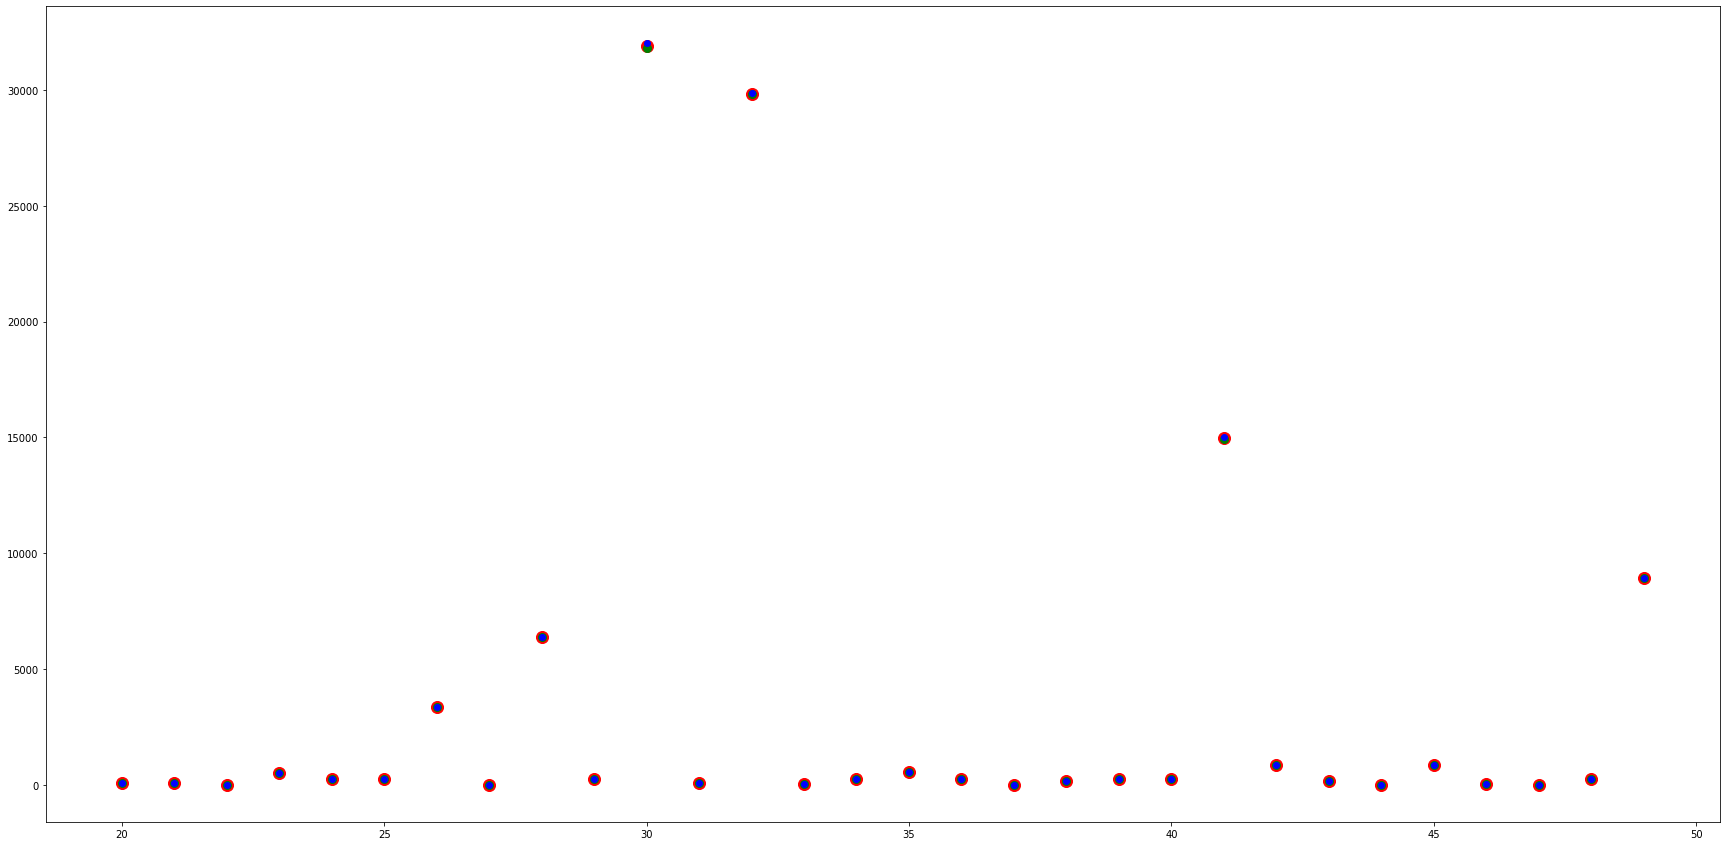

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(20,50)
plt.figure(figsize=(30,15))
plt.plot(x,y_test[20:50],'ro',markersize=12)
plt.plot(x,y_lower[20:50],'go',markersize = 8)
plt.plot(x,y_upper[20:50],'bo',markersize = 6)


plt.show()

 CQR obtained valid prediction interval. 

We now turn to compare the efficiency (average length) of our CQR method to the split conformal and its locally adaptive variant.

## Split conformal

In this section we implement the usual split conformal method. Specifically, we use the proper training and calibration subsets; train a random forest regressor on the first set, and calibrate the intervals on the second set by computing the absolute residual error. Notice that the random forests regressor **estimates the conditional mean** of $Y_i$ given $X_i=x$.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from nonconformist.nc import RegressorNormalizer
from nonconformist.nc import AbsErrorErrFunc

# define the conditonal mean estimator as random forests
mean_estimator = RandomForestRegressor(n_estimators=n_estimators,
                                       min_samples_leaf=min_samples_leaf,
                                       max_features=max_features,
                                       random_state=random_state)

# define a conformal prediction object 
nc = RegressorNc(mean_estimator, AbsErrorErrFunc())

# build a regualr split conformal prediction object 
icp = IcpRegressor(nc)

# fit the conditional mean regression to the proper training data
icp.fit(x_train[idx_train], y_train[idx_train])

# compute the absolute residual error on calibration data
icp.calibrate(x_train[idx_cal], y_train[idx_cal])

# produce predictions for the test set, with confidence equal to significance
predictions = icp.predict(x_test, significance=alpha)
y_lower = predictions[:,0]
y_upper = predictions[:,1]

# compute the conditional mean estimation
pred = mean_estimator.predict(x_test)

# display the results
#plot_func(x=x_test,y=y_test,y_u=y_upper,y_l=y_lower,pred=pred,shade_color=split_color,
#          method_name="Split:",title="Random Forests (mean regression)",
#          filename="illustration_split_rf.png",save_figures=save_figures)

# compute and display the average coverage
in_the_range = np.sum((y_test >= y_lower) & (y_test <= y_upper))
print("Random Forests: Percentage in the range (expecting " + str(100*(1-alpha)) + "%):",
      in_the_range / len(y_test) * 100)

# compute length of the interval per each test point
length_split_rf = y_upper - y_lower

# compute and display the average length
print("Random Forests: Average length:", np.mean(length_split_rf))

Random Forests: Percentage in the range (expecting 90.0%): 90.03496503496503
Random Forests: Average length: 3.5200000000005014


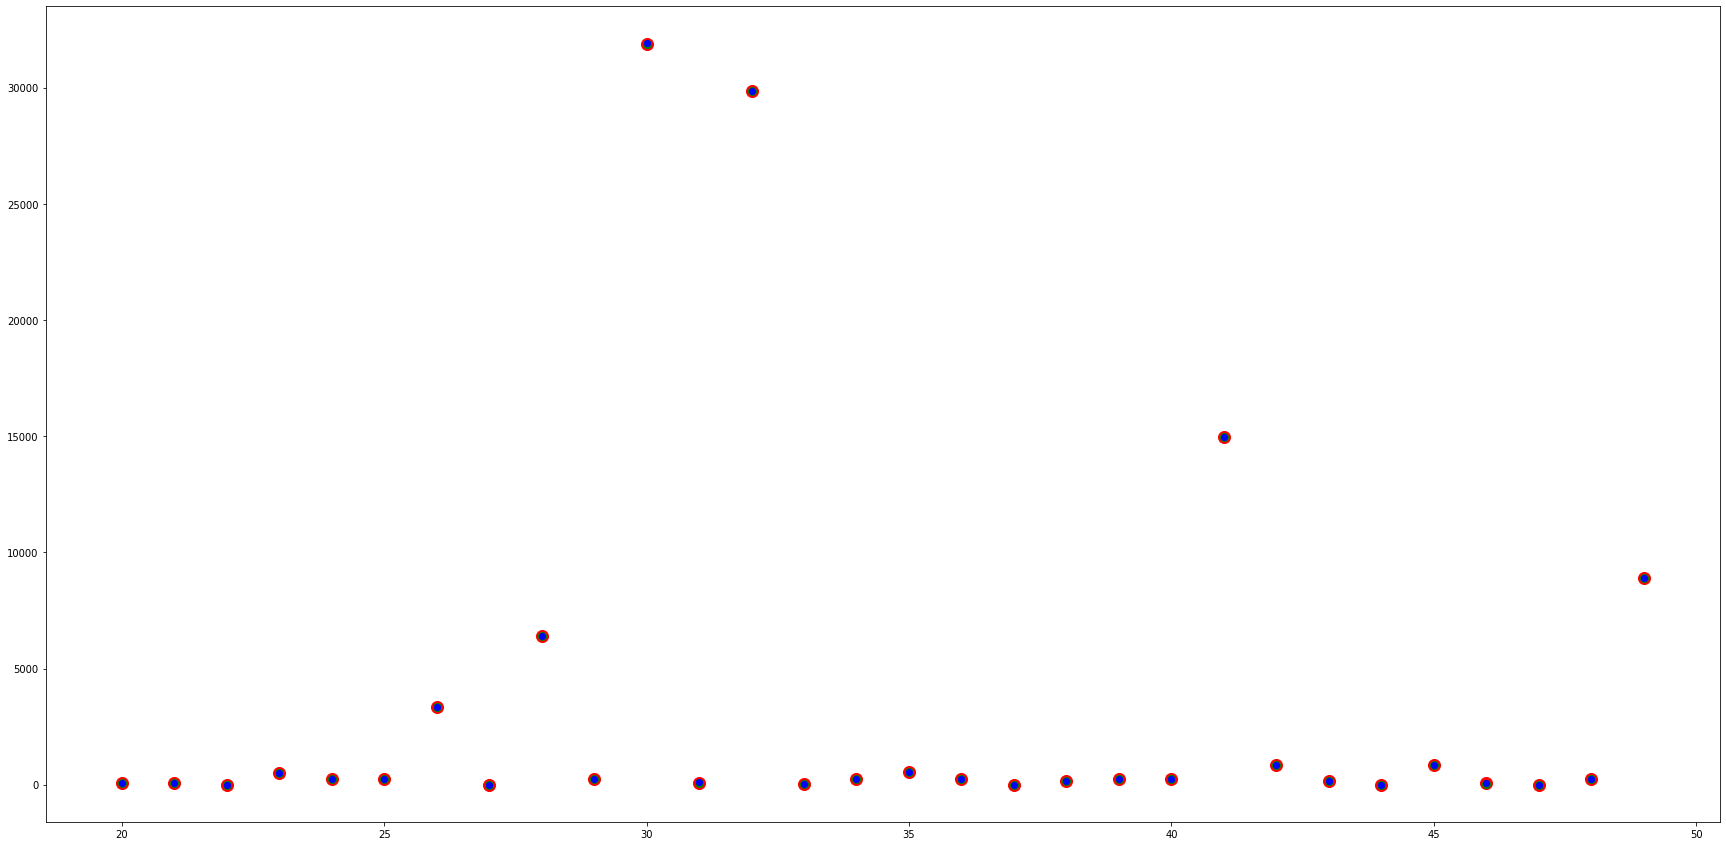

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(20,50)
plt.figure(figsize=(30,15))
plt.plot(x,y_test[20:50],'ro',markersize=12)
plt.plot(x,y_lower[20:50],'go',markersize = 8)
plt.plot(x,y_upper[20:50],'bo',markersize = 6)


plt.show()

 Notice that the average length of the constructed interval is greater than the one obtained by CQR.


## Local conformal

In this section we implement a well-known variant of the locally weighted split conformal method [3], aiming at constructing adaptive intervals. As in the usual split conformal, this method fits a **conditional mean regression function** to the proper training set (formulated as random forest regressor). In the next step, the locally weighted method fits another (second conditional mean regressor) random forests model to the absolute residuals of the proper training set (MAD estimator), this in order to scale the future test residuals. Just as before, the calibration set is used to construct the conformal interval.

In [ ]:
# define the conditonal mean estimator as random forests (used to predict the labels)
mean_estimator = RandomForestRegressor(n_estimators=n_estimators,
                                       min_samples_leaf=min_samples_leaf,
                                       max_features=max_features,
                                       random_state=random_state)

# define the MAD estimator as random forests (used to scale the absolute residuals)
mad_estimator = RandomForestRegressor(n_estimators=n_estimators,
                                      min_samples_leaf=min_samples_leaf,
                                      max_features=max_features,
                                      random_state=random_state)

# define a conformal normalizer object that uses the two regression functions.
# The nonconformity score is absolute residual error
normalizer = RegressorNormalizer(mean_estimator,
                                 mad_estimator,
                                 AbsErrorErrFunc())

# define the final local conformal object 
nc = RegressorNc(mean_estimator, AbsErrorErrFunc(), normalizer)

# build the split local conformal object
icp = IcpRegressor(nc)

# fit the conditional mean and MAD models to proper training data
icp.fit(x_train[idx_train], y_train[idx_train])

# compute the absolute residual error on calibration data
icp.calibrate(x_train[idx_cal], y_train[idx_cal])

# produce predictions for the test set, with confidence equal to significance
predictions = icp.predict(x_test, significance=alpha)

# extract the lower and upper bound of the prediction interval
y_lower = predictions[:,0]
y_upper = predictions[:,1]

# compute the conditional mean estimation
pred = mean_estimator.predict(x_test)


# compute and display the average coverage
in_the_range = np.sum((y_test >= y_lower) & (y_test <= y_upper))
print("Local Random Forests: Percentage in the range (expecting " + str(100*(1-alpha)) + "%):",
      in_the_range / len(y_test) * 100)

# compute length of the interval per each test point
length_local_rf = y_upper - y_lower

# compute and display the average length
print("Local Random Forests: Average length:", np.mean(length_local_rf))

Local Random Forests: Percentage in the range (expecting 90.0%): 89.91841491841492
Local Random Forests: Average length: 22.417516049985025


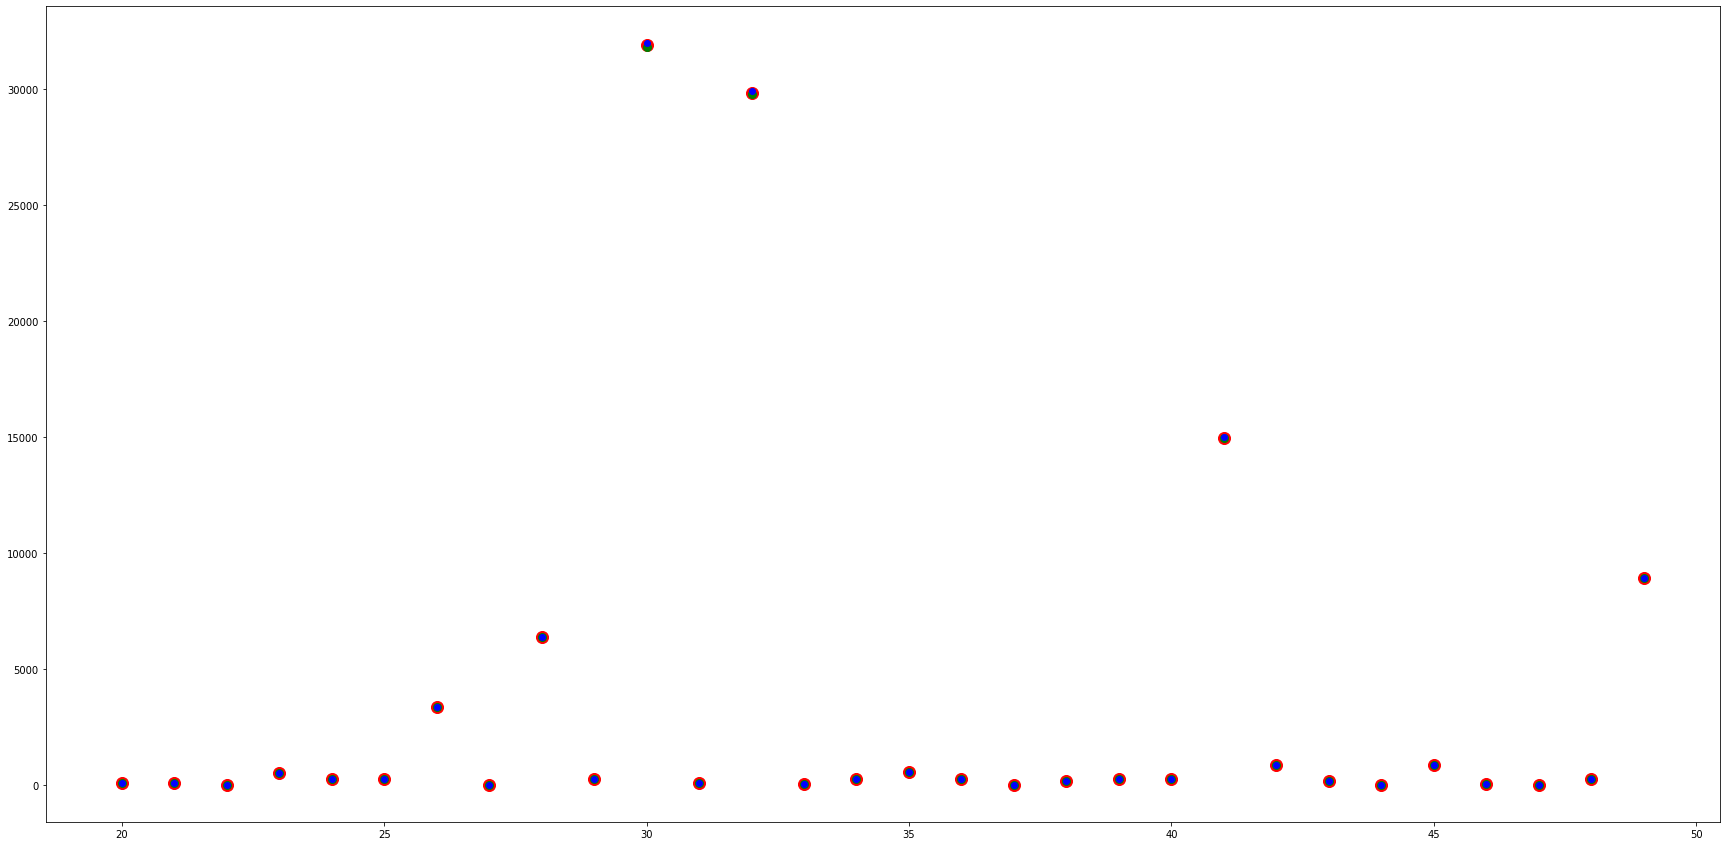

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(20,50)
plt.figure(figsize=(30,15))
plt.plot(x,y_test[20:50],'ro',markersize=12)
plt.plot(x,y_lower[20:50],'go',markersize = 8)
plt.plot(x,y_upper[20:50],'bo',markersize = 6)


plt.show()

The prediction intervals constructed by the local split conformal also achieves valid coverage. The intervals are partially adaptive, resulting in slightly shorter intervals than the usual split conformal, but inferior than the ones obtained by CQR.


## Local conformal with median regression

To improve robustness to outliers, one might try to estimate the conditional median instead of the conditional mean in locally adaptive conformal prediction. The residuals are scaled in the usual way, by classical regression via random forests. We implement this strategy in the following section.

In [ ]:
from skgarden import RandomForestQuantileRegressor
from nonconformist.base import RegressorAdapter

# replace conditional mean by conditional median estimator
class MedianRegressorAdapter(RegressorAdapter):
    """ Conditional median estimator, defined as quantile random forests (QRF)
    
    References
    ----------
    .. [1]  Meinshausen, Nicolai. "Quantile regression forests."
            Journal of Machine Learning Research 7.Jun (2006): 983-999.
                
    """
    def __init__(self, model, fit_params=None, quantiles=[50], params=None):
        super(MedianRegressorAdapter, self).__init__(model, fit_params)
        # Instantiate model
        self.quantiles = quantiles
        self.cv_quantiles = self.quantiles
        self.params = params
        self.rfqr = RandomForestQuantileRegressor(random_state=params["random_state"],
                                                  min_samples_leaf=params["min_samples_leaf"],
                                                  n_estimators=params["n_estimators"],
                                                  max_features=params["max_features"])
        
    def fit(self, x, y):
        self.rfqr.fit(x, y)
    
    def predict(self, x):
        return self.rfqr.predict(x, quantile=50)

# define the conditional median model as random forests regressor (used to predict the labels)
median_estimator = MedianRegressorAdapter(model=None,
                                          fit_params=None,
                                          quantiles=[50],
                                          params=params_qforest)

# define the MAD estimator as usual (mean) random forests regressor (used to scale the absolute residuals)
mad_estimator = RandomForestRegressor(n_estimators=n_estimators,
                                      min_samples_leaf=min_samples_leaf,
                                      max_features=max_features,
                                      random_state=random_state)

# define a conformal normalizer object that uses the two regression functions.
# The nonconformity score is absolute residual error
normalizer = RegressorNormalizer(median_estimator,
                                 mad_estimator,
                                 AbsErrorErrFunc())

# define the final local conformal object 
nc = RegressorNc(median_estimator, AbsErrorErrFunc(), normalizer)

# build the split local conformal object
icp = IcpRegressor(nc)

# fit the conditional mean and usual MAD models to proper training data
icp.fit(x_train[idx_train], y_train[idx_train])

# compute the absolute residual error on calibration data
icp.calibrate(x_train[idx_cal], y_train[idx_cal])

# produce predictions for the test set, with confidence equal to significance
predictions = icp.predict(x_test, significance=alpha)
y_lower = predictions[:,0]
y_upper = predictions[:,1]

# compute the conditional median estimation
pred = median_estimator.predict(x_test)

# display the results
#plot_func(x=x_test,y=y_test,y_u=y_upper,y_l=y_lower,pred=pred,shade_color=local_color,
#          method_name="Local (median):",title="Random Forests Local (median regression)",
#          filename="illustration_split_local_median_rf.png",save_figures=save_figures)

# compute and display the average coverage
in_the_range = np.sum((y_test >= y_lower) & (y_test <= y_upper))
print("Local Median Random Forests: Percentage in the range (expecting " + str(100*(1-alpha)) + "%):",
      in_the_range / len(y_test) * 100)

# compute and display the average length
print("Local Median Random Forests: Average length:", np.mean(y_upper - y_lower))

Local Median Random Forests: Percentage in the range (expecting 90.0%): 89.73526473526474
Local Median Random Forests: Average length: 25.33538277362022


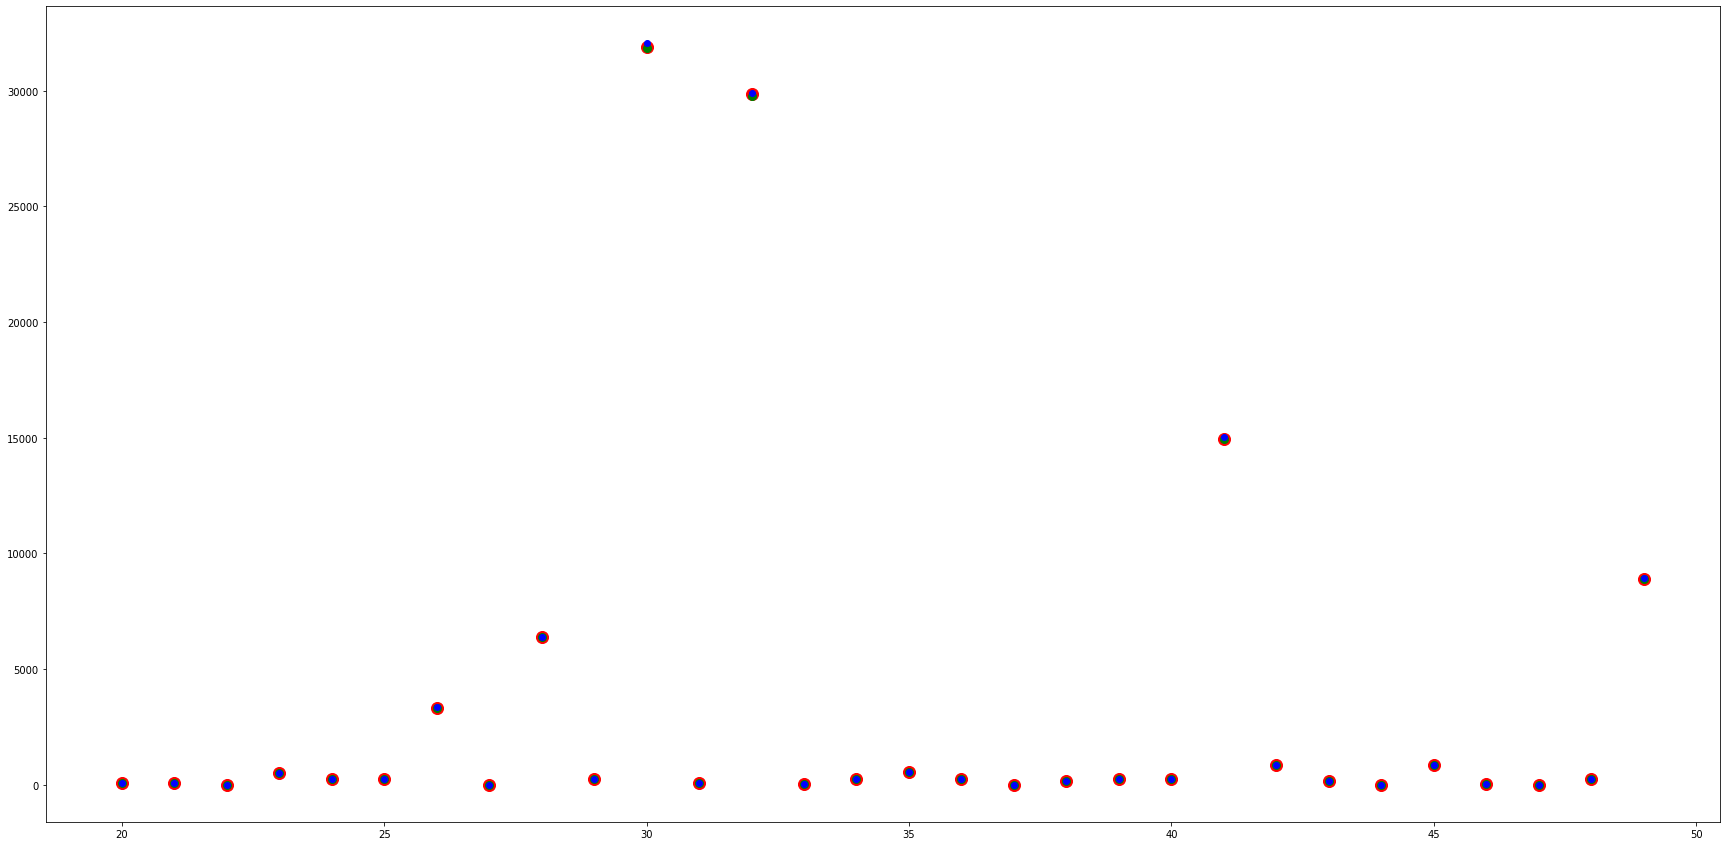

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(20,50)
plt.figure(figsize=(30,15))
plt.plot(x,y_test[20:50],'ro',markersize=12)
plt.plot(x,y_lower[20:50],'go',markersize = 8)
plt.plot(x,y_upper[20:50],'bo',markersize = 6)


plt.show()